In [1]:
### importing QComp ###
include("../src/QComp.jl")
using .QComp

using Yao
using YaoPlots
using LinearAlgebra
using PyPlot
using Random

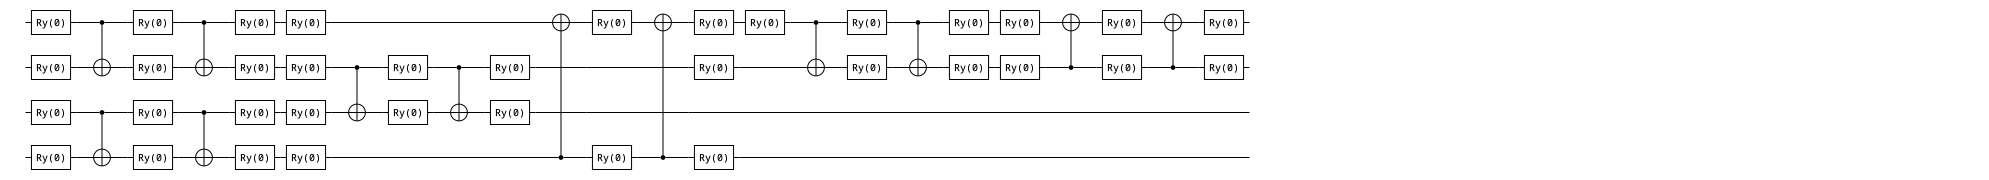

In [2]:
circ = build_QCNN(4, ansatz=conv_Ry2)
YaoPlots.plot(circ)

In [3]:
#Example use (random states vs uniform state)

seed = 2
Random.seed!(seed)

n = 4 # preferably a power of 2

states1 = [rand_state(n) for i=1:10]
states2 = [uniform_state(n) for i=1:10]
states = vcat([states1, states2]...)
labels = vcat([repeat([1],10), repeat([-1],10)]...)

test_states1 = [rand_state(n) for i=1:10]
test_states2 = [uniform_state(n) for i=1:10]
test_states = vcat([test_states1, test_states2]...)
test_labels = vcat([repeat([1],10), repeat([-1],10)]...)

d1 = Data(states, labels);
d2 = Data(test_states, test_labels);

In [4]:
iters = 300
# Using ADAM optimiser in source code.
# See https://fluxml.ai/Optimisers.jl/dev/api/#Optimisation-Rules for different optimisers.
lr = 0.05  # Start with lr=0.1. Reduce to lr=0.01 if optimisation is not smooth.
sig = true
ansatz = conv_SU4


circ = build_QCNN(n, ansatz=ansatz)
#p = GenericParams(n=n, circ=circ)
p = InvariantParams(n=n, circ=circ, ansatz=ansatz)
initialize_params(p);

In [5]:
params, loss_track, tr_track, te_track, tr_preds, te_preds = train_test_model(d1, d2, p, iters, sig, lr; output=false)

Initial: loss = 1.3837593926292424,tr_acc = 0.65, te_acc = 0.85
Final: loss = 0.0018219552119156234,tr_acc = 1.0, te_acc = 0.75


([5.262407758450158, 5.66757482580183, 6.388865657302517, 0.39120719805635484, 3.428093930449788, 4.369601299326933, 4.655562241831423, 1.3495649389051654, 5.9328314309857815, 5.587371650434164  …  3.7814768165049557, 6.458174127484949, 3.442450645018062, 1.9860329239154098, 3.7352909732550788, 2.6667150125851937, 5.08485858779689, 1.1659151688074711, 4.424713967104552, 5.548046955788005], [1.3837593926292424, 0.965350005827832, 0.9094641849090737, 0.899780305973205, 0.7410226786706579, 0.5398744779449166, 0.3915754100136749, 0.31707971480404123, 0.2932262931892094, 0.2914221975590906  …  0.0018555391047005263, 0.0018518259696774387, 0.0018481086686214462, 0.001844386994781666, 0.0018406607549663592, 0.0018369297692086527, 0.0018331938704363206, 0.0018294529041457915, 0.0018257067280808424, 0.0018219552119156234], [0.65, 0.65, 0.65, 0.75, 0.75, 0.85, 0.9, 0.95, 0.95, 0.95  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.85, 0.8, 0.8, 0.8, 0.8, 0.75, 0.75, 0.75, 0.7, 0.7  …  0.

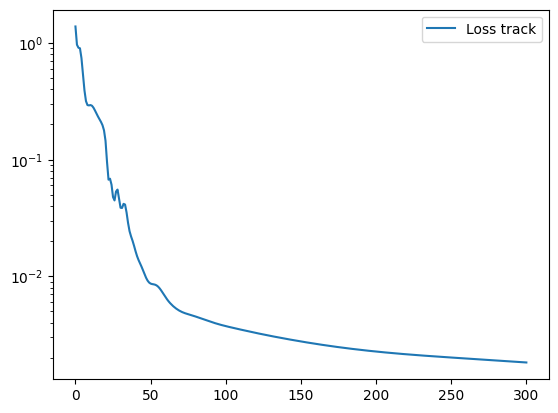

In [6]:
PyPlot.semilogy(0:iters, loss_track, label="Loss track")
PyPlot.legend()
PyPlot.display_figs()

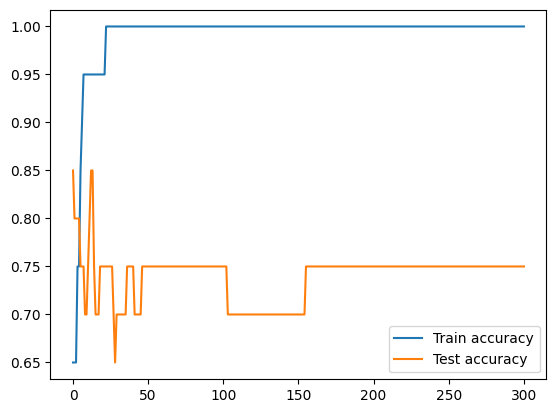

In [7]:
PyPlot.plot(0:iters, tr_track, label="Train accuracy")
PyPlot.plot(0:iters, te_track, label="Test accuracy")
PyPlot.legend()
PyPlot.display_figs()

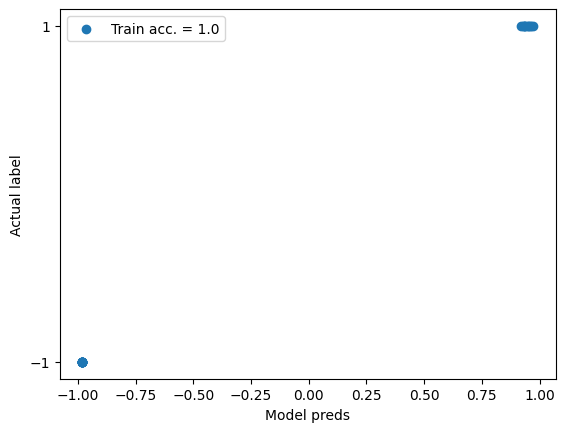

In [8]:
PyPlot.scatter(tr_preds, labels, label="Train acc. = $(round(tr_track[end],digits=2))")
#PyPlot.scatter(te_preds, test_labels, label="Test acc. = $(round(te_track[end],digits=2))")
PyPlot.xlabel("Model preds")
PyPlot.ylabel("Actual label")
PyPlot.yticks(-1:2:1)
PyPlot.legend()
PyPlot.display_figs()